# gluonts12-end_dates

In [1]:
# !pip install mxnet=="1.4.1"

In [2]:
# !pip install gluonts

In [1]:
import gluonts
print(gluonts.__version__)

import mxnet
print(mxnet.__version__)

# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar

0.4.1
1.4.1


INFO:root:Using CPU


In [2]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_id', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_qu

In [3]:
dataname = "m4_monthly_end032014"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.


In [4]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

# check length of the series
print("length train dataset", len(dataset.train))
print("length test dataset", len(dataset.train))


dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])
length train dataset 1807
length test dataset 1807


In [5]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='M'),
 'item_id': 'M3991',
 'target': array([ 1499.,  1677.,  2533.,  1834.,  2922.,  2460.,  2892.,  1969.,
         2781.,  2988.,  3035.,  3172.,  1818.,  2828.,  1979.,  2821.,
         2181.,  2287.,  2320.,  2839.,  1482.,  3094.,  2410.,  2752.,
         1728.,  2112.,  1946.,  2738.,  1812.,  2142.,  2365.,  3492.,
         2875.,  3992.,  1805.,  3433.,  1287.,  2497.,  3733.,  3392.,
         3690.,  4116.,  3163.,  5815.,  4334.,  3794.,  5340.,  7929.,
        15301.,  5824.,  4470.,  7728.,  4461.,  5206.,  5083., 16296.,
         3479.,  3932.,  5383.,  3772.,  3110.,  3995.,  4393.,  5821.,
         5362.,  3344.,  4723.,  4053.,  4007.,  7126.,  3785.,  2627.,
         1963.,  3676.,  5577.,  3394.,  2389.,  1922.,  2924.,  3221.,
         3411.,  4006.,  3108.,  3576.,  2874.,  2759.,  3644.,  3669.,
         4345.,  3471.,  4172.,  3711.,  4095.,  5106.,  6184.,  5464.,
         3786.,  3505.,  4681.,  3651.,  7627.,  55

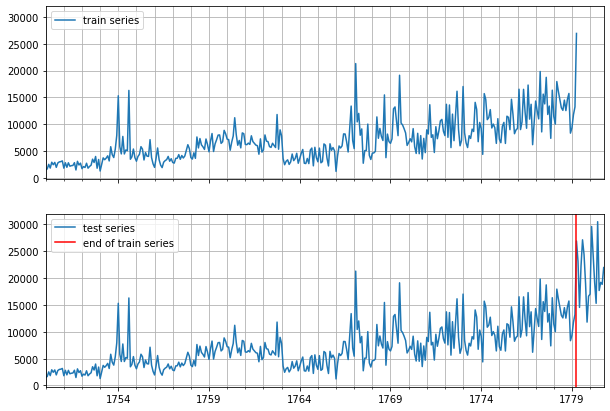

In [6]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [7]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [8]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df

## Results

In [9]:
dataname

'm4_monthly_end032014'

In [13]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

Seed: 43


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.25it/s, avg_epoch_loss=7.84]
INFO:root:Epoch[0] Elapsed time 8.917 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.835631
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.65it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[1] Elapsed time 7.905 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.265816
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.47it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[2] Elapsed time 8.025 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.081766
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.02it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[3] Elapsed time 8.326 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

100%|██████████| 100/100 [00:11<00:00,  8.89it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[72] Elapsed time 11.255 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.588355
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:08<00:00, 12.04it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[73] Elapsed time 8.313 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.602243
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 12.90it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[74] Elapsed time 7.758 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.521852
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 12.58it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[75] Elapsed time 7.950 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.539460
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:08<00:00, 12.45it/s, avg_epo

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.095018  0.186394  16.173892            0.170274            0.133715   

   seed  epochs  num_batches  
0    43     100          100  
Seed: 44


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.35it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[0] Elapsed time 9.688 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.699839
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.15it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[1] Elapsed time 10.927 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.208197
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.63it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[2] Elapsed time 9.417 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.089057
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.30it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[3] Elapsed time 12.054 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_lo

100%|██████████| 100/100 [00:07<00:00, 12.67it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[72] Elapsed time 7.890 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.597689
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 12.63it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[73] Elapsed time 7.931 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.547988
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:08<00:00, 11.47it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[74] Elapsed time 8.733 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.491522
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:08<00:00, 12.48it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[75] Elapsed time 8.031 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.573877
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:08<00:00, 11.95it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[76] Elapsed time 8.370

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.113479  0.186524  15.712464            0.173148            0.134562   

   seed  epochs  num_batches  
0    44     100          100  
Seed: 45


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.39it/s, avg_epoch_loss=7.87]
INFO:root:Epoch[0] Elapsed time 8.078 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.872864
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.71it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[1] Elapsed time 7.876 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.253729
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.95it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[2] Elapsed time 7.727 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.058174
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.77it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[3] Elapsed time 7.834 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

100%|██████████| 100/100 [00:07<00:00, 12.90it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[72] Elapsed time 7.750 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.521201
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.92it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[73] Elapsed time 10.084 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.550180
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 12.54it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[74] Elapsed time 7.976 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.548367
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:07<00:00, 12.86it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[75] Elapsed time 7.776 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.553921
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:07<00:00, 12.98it/s, avg_e

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.214038  0.192075  17.28293            0.184116            0.139715    45   

   epochs  num_batches  
0     100          100  
Seed: 46


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.82it/s, avg_epoch_loss=7.88]
INFO:root:Epoch[0] Elapsed time 8.478 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.877563
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.62it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[1] Elapsed time 7.922 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.261975
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.17it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[2] Elapsed time 8.222 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.082287
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.06it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[3] Elapsed time 9.937 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

INFO:root:Epoch[72] Learning rate is 0.000125
100%|██████████| 100/100 [00:08<00:00, 12.47it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[72] Elapsed time 8.020 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.611751
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 100/100 [00:07<00:00, 12.90it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[73] Elapsed time 7.751 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.533270
INFO:root:Loading parameters from best epoch (43)
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:07<00:00, 12.88it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[74] Elapsed time 7.786 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.533245
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:07<00:00, 12.57it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[75] Elapsed time 7.976 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.589262
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|███

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.11054  0.189684  16.741209            0.175028            0.141047    46   

   epochs  num_batches  
0     100          100  
Seed: 47


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.35it/s, avg_epoch_loss=7.87]
INFO:root:Epoch[0] Elapsed time 8.098 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.868606
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.86it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[1] Elapsed time 7.776 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.285495
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.63it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[2] Elapsed time 7.937 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.081832
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.92it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[3] Elapsed time 7.742 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

100%|██████████| 100/100 [00:10<00:00,  9.89it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[72] Elapsed time 10.119 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.489371
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:08<00:00, 12.47it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[73] Elapsed time 8.036 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.525625
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 12.65it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[74] Elapsed time 7.910 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.582652
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 12.94it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[75] Elapsed time 7.734 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.563914
INFO:root:Loading parameters from best epoch (55)
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:07<00:00, 12.81it/s, avg_ep

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.128267  0.188297  15.982008            0.175743            0.134602   

   seed  epochs  num_batches  
0    47     100          100  
Seed: 48


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.55it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[0] Elapsed time 7.966 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.701239
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.77it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[1] Elapsed time 7.853 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.259401
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.85it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[2] Elapsed time 8.462 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.126004
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.80it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[3] Elapsed time 9.263 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss

INFO:root:Epoch[72] Learning rate is 0.000125
100%|██████████| 100/100 [00:09<00:00, 11.07it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[72] Elapsed time 9.040 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.559569
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 100/100 [00:08<00:00, 11.47it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[73] Elapsed time 8.725 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.499015
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:09<00:00, 10.92it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[74] Elapsed time 9.168 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.541010
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:08<00:00, 12.17it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[75] Elapsed time 8.223 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.553922
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:08<00:00, 11.76it/s, avg_epoch

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.198774  0.196303  18.347179            0.183892            0.144892   

   seed  epochs  num_batches  
0    48     100          100  
Seed: 49


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.67it/s, avg_epoch_loss=7.83]
INFO:root:Epoch[0] Elapsed time 17.666 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.826908
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.43it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[1] Elapsed time 13.471 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.310908
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.20it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[2] Elapsed time 12.208 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.182963
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.06it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[3] Elapsed time 12.409 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch

INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.22it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[73] Elapsed time 8.932 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.488250
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.54it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[74] Elapsed time 7.977 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.540201
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.51it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[75] Elapsed time 8.008 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.557754
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.51it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[76] Elapsed time 7.995 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.518074
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.53it/s, avg_epoch_loss=6.55]
IN

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.21926  0.193375  18.095816            0.178724             0.13577    49   

   epochs  num_batches  
0     100          100  
Seed: 50


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.11it/s, avg_epoch_loss=7.72]
INFO:root:Epoch[0] Elapsed time 8.267 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.723833
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.45it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[1] Elapsed time 8.035 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.270346
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.99it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[2] Elapsed time 10.015 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.065984
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.70it/s, avg_epoch_loss=7]
INFO:root:Epoch[3] Elapsed time 8.558 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.484912
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:10<00:00,  9.28it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[73] Elapsed time 10.783 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.538019
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:10<00:00,  9.48it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[74] Elapsed time 10.560 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.551836
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:11<00:00,  9.04it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[75] Elapsed time 11.071 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.535738
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:09<00:00, 10.10it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[76] Elapsed time 9.909 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.519809
INFO:root:Epoch[77] Learning rate is 0.0005
100%|

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.139888  0.18847  16.218417             0.17639            0.137843    50   

   epochs  num_batches  
0     100          100  
Seed: 51


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:19<00:00,  5.15it/s, avg_epoch_loss=7.84]
INFO:root:Epoch[0] Elapsed time 19.421 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.835717
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  5.99it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[1] Elapsed time 16.717 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.262232
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.66it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[2] Elapsed time 15.031 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.057119
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.75it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[3] Elapsed time 17.391 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.544234
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:08<00:00, 11.79it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[73] Elapsed time 8.484 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.516618
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:09<00:00, 10.13it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[74] Elapsed time 9.890 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.480791
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:10<00:00,  9.12it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[75] Elapsed time 10.968 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.503605
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:09<00:00, 10.27it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[76] Elapsed time 9.734 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.566909
INFO:root:Epoch[77] Learning rate is 0.0005
100%|███

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.132541  0.190542  16.246382            0.176915            0.137895   

   seed  epochs  num_batches  
0    51     100          100  
m4_monthly_end032014


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.095018,0.186394,16.173892,0.170274,0.133715,43,100,100
0,1.113479,0.186524,15.712464,0.173148,0.134562,44,100,100
0,1.214038,0.192075,17.282930,0.184116,0.139715,45,100,100
0,1.110540,0.189684,16.741209,0.175028,0.141047,46,100,100
0,1.128267,0.188297,15.982008,0.175743,0.134602,47,100,100
0,1.198774,0.196303,18.347179,0.183892,0.144892,48,100,100
0,1.219260,0.193375,18.095816,0.178724,0.135770,49,100,100
0,1.139888,0.188470,16.218417,0.176390,0.137843,50,100,100
0,1.132541,0.190542,16.246382,0.176915,0.137895,51,100,100


In [10]:
results = pd.DataFrame()

for i in range(43, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

Seed: 43


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.12it/s, avg_epoch_loss=7.84]
INFO:root:Epoch[0] Elapsed time 9.005 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.835631
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.01it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[1] Elapsed time 7.692 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.265816
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.31it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[2] Elapsed time 8.863 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.081766
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.82it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[3] Elapsed time 7.801 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=6.552217
INFO:root:Epoch[36] Learning rate is 0.0005
100%|██████████| 100/100 [00:10<00:00,  9.76it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[36] Elapsed time 10.252 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.558982
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:09<00:00, 10.76it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[37] Elapsed time 9.294 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.596080
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:15<00:00,  6.66it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[38] Elapsed time 15.030 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.650066
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:08<00:00, 12.21it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[39] Elapsed time 8.194 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.552741
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██

100%|██████████| 100/100 [00:08<00:00, 12.04it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[72] Elapsed time 8.310 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.588355
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:08<00:00, 12.34it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[73] Elapsed time 8.115 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.602243
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:08<00:00, 12.35it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[74] Elapsed time 8.097 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.521852
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:08<00:00, 12.10it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[75] Elapsed time 8.271 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.539460
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:08<00:00, 12.31it/s, avg_epoc

INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 12.21it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[108] Elapsed time 8.195 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=6.576326
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 12.02it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[109] Elapsed time 8.322 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.495018
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 12.08it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[110] Elapsed time 8.279 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.542639
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 12.47it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[111] Elapsed time 8.017 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.580403
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 12.05it/s, avg_epoch_l

INFO:root:Epoch[144] Elapsed time 9.256 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=6.524377
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  9.02it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[145] Elapsed time 11.100 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=6.553188
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:20<00:00,  4.78it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[146] Elapsed time 20.918 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.559152
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.37it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[147] Elapsed time 10.715 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.467844
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 11.70it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[148] Elapsed time 8.557 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6

INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 11.32it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[181] Elapsed time 8.838 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=6.561287
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:12<00:00,  8.05it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[182] Elapsed time 12.434 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.554398
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:14<00:00,  6.90it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[183] Elapsed time 14.507 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.448481
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.46it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[184] Elapsed time 10.577 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.516860
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.91it/s, avg_epo

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.106029  0.186431  15.794435            0.171791            0.133344   

   seed  epochs  num_batches  
0    43     200          100  
Seed: 44


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.38it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[0] Elapsed time 13.566 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.699839
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.13it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[1] Elapsed time 8.249 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.208197
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.25it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[2] Elapsed time 8.172 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.089057
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.96it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[3] Elapsed time 9.131 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=6.586926
INFO:root:Epoch[36] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.24it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[36] Elapsed time 12.142 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.671832
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:13<00:00,  7.66it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[37] Elapsed time 13.063 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.626297
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:11<00:00,  8.97it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[38] Elapsed time 11.149 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.602410
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:10<00:00,  9.10it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[39] Elapsed time 10.987 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.577701
INFO:root:Epoch[40] Learning rate is 0.0005
100%|

100%|██████████| 100/100 [00:12<00:00,  8.26it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[72] Elapsed time 12.117 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.597689
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:16<00:00,  6.19it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[73] Elapsed time 16.147 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.547988
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  7.82it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[74] Elapsed time 12.789 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.491522
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  8.14it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[75] Elapsed time 12.281 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.573877
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  7.99it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[76] Elapsed time 1

INFO:root:Epoch[108] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:14<00:00,  6.89it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[108] Elapsed time 14.516 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=6.491512
INFO:root:Epoch[109] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:16<00:00,  6.07it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[109] Elapsed time 16.486 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.532908
INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:18<00:00,  5.38it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[110] Elapsed time 18.587 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.600689
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:21<00:00,  4.61it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[111] Elapsed time 21.708 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.548676
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:28<00:00,  3.

INFO:root:Epoch[144] Learning rate is 5e-05
100%|██████████| 100/100 [00:13<00:00,  7.41it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[144] Elapsed time 13.506 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=6.494700
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:13<00:00,  7.64it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[145] Elapsed time 13.093 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=6.559668
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:12<00:00,  7.95it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[146] Elapsed time 12.581 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.534048
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:13<00:00,  7.22it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[147] Elapsed time 13.866 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.473048
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:13<00:00,  7.61it/s, avg_ep

100%|██████████| 100/100 [00:16<00:00,  6.00it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[180] Elapsed time 16.674 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=6.512979
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.22it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[181] Elapsed time 19.358 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=6.445894
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:20<00:00,  4.82it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[182] Elapsed time 20.772 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.514762
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:21<00:00,  4.58it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[183] Elapsed time 21.834 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.591209
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:15<00:00,  6.29it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[184] Elapsed t

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.089355  0.185533  15.613339             0.17113            0.135385   

   seed  epochs  num_batches  
0    44     200          100  
Seed: 45


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.41it/s, avg_epoch_loss=7.87]
INFO:root:Epoch[0] Elapsed time 13.502 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.872864
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.78it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[1] Elapsed time 11.399 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.253729
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.79it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[2] Elapsed time 12.845 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.058174
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.90it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[3] Elapsed time 12.668 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=6.593319
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.22it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[36] Elapsed time 10.849 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.681244
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.24it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[37] Elapsed time 10.819 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.611195
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  9.06it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[38] Elapsed time 11.034 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.582967
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.76it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[39] Elapsed time 11.413 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.568753
INFO:root:Epoch[40] Learning rate is 0.001
100%|████

INFO:root:Epoch[71] Evaluation metric 'epoch_loss'=6.550262
INFO:root:Epoch[72] Learning rate is 0.00025
100%|██████████| 100/100 [00:11<00:00,  8.59it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[72] Elapsed time 11.654 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.521201
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:13<00:00,  7.60it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[73] Elapsed time 13.167 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.550180
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:17<00:00,  5.72it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[74] Elapsed time 17.493 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.548367
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:13<00:00,  7.23it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[75] Elapsed time 13.835 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.

INFO:root:Epoch[107] Elapsed time 26.770 seconds
INFO:root:Epoch[107] Evaluation metric 'epoch_loss'=6.474226
INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:15<00:00,  6.49it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[108] Elapsed time 15.426 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=6.544688
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.63it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[109] Elapsed time 10.396 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.564087
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:17<00:00,  5.61it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[110] Elapsed time 17.837 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.537058
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.79it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[111] Elapsed time 11.379 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'

INFO:root:Epoch[143] Evaluation metric 'epoch_loss'=6.529065
INFO:root:Epoch[144] Learning rate is 5e-05
100%|██████████| 100/100 [00:31<00:00,  3.13it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[144] Elapsed time 31.909 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=6.518124
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:26<00:00,  3.77it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[145] Elapsed time 26.555 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=6.519262
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:43<00:00,  2.30it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[146] Elapsed time 43.506 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.468357
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:13<00:00,  7.57it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[147] Elapsed time 14.119 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.501055
INFO:root:Epoch[148] Learning rate is 5e

INFO:root:Epoch[180] Learning rate is 5e-05
100%|██████████| 100/100 [00:16<00:00,  6.19it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[180] Elapsed time 16.160 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=6.563778
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.30it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[181] Elapsed time 18.894 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=6.550621
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.08it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[182] Elapsed time 19.686 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.480160
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:14<00:00,  6.79it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[183] Elapsed time 14.738 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.511376
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.36it/s, avg_ep

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.116024  0.186198  15.778156            0.175491            0.136718   

   seed  epochs  num_batches  
0    45     200          100  
Seed: 46


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.33it/s, avg_epoch_loss=7.88]
INFO:root:Epoch[0] Elapsed time 18.780 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.877563
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.86it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[1] Elapsed time 17.070 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.261975
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.32it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[2] Elapsed time 18.816 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.082287
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.86it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[3] Elapsed time 17.074 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=6.648204
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.70it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[36] Elapsed time 12.999 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.652198
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.55it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[37] Elapsed time 11.700 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.642744
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.78it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[38] Elapsed time 11.403 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.682189
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.37it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[39] Elapsed time 13.569 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.604920
INFO:root:Epoch[40] Learning rate is 0.001
100%|█████

INFO:root:Epoch[71] Evaluation metric 'epoch_loss'=6.539343
INFO:root:Epoch[72] Learning rate is 0.000125
100%|██████████| 100/100 [00:16<00:00,  6.05it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[72] Elapsed time 16.524 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.611751
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 100/100 [00:17<00:00,  5.87it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[73] Elapsed time 17.047 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.533270
INFO:root:Loading parameters from best epoch (43)
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:16<00:00,  6.00it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[74] Elapsed time 16.666 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.533245
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:14<00:00,  6.83it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[75] Elapsed time 14.657 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'

INFO:root:Epoch[107] Evaluation metric 'epoch_loss'=6.585631
INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:14<00:00,  6.75it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[108] Elapsed time 14.822 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=6.588659
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:12<00:00,  8.22it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[109] Elapsed time 12.173 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.494901
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.98it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[110] Elapsed time 11.138 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.509699
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.98it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[111] Elapsed time 11.154 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.583906
INFO:root:Epoch[112] Learning rate is 5

INFO:root:Epoch[144] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.61it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[144] Elapsed time 11.633 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=6.506371
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.72it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[145] Elapsed time 11.472 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=6.546575
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.99it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[146] Elapsed time 11.122 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.601491
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.71it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[147] Elapsed time 11.542 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.547952
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.78it/s, avg_epo

100%|██████████| 100/100 [00:20<00:00,  4.95it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[180] Elapsed time 20.210 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=6.580101
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:21<00:00,  4.64it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[181] Elapsed time 21.560 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=6.515926
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:25<00:00,  3.97it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[182] Elapsed time 25.186 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.499670
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:14<00:00,  7.03it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[183] Elapsed time 14.247 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.529459
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:13<00:00,  7.24it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[184] Elapsed t

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.108138  0.189742  16.783807            0.174985            0.142708   

   seed  epochs  num_batches  
0    46     200          100  
Seed: 47


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.99it/s, avg_epoch_loss=7.87]
INFO:root:Epoch[0] Elapsed time 12.542 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.868606
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.03it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[1] Elapsed time 12.464 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.285495
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.36it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[2] Elapsed time 8.811 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.081832
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.55it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[3] Elapsed time 9.476 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_l

INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.56it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[36] Elapsed time 9.484 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.620932
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.43it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[37] Elapsed time 9.589 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.624912
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.96it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[38] Elapsed time 9.132 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.618063
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.23it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[39] Elapsed time 9.785 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.601964
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.81it/s, avg_epoch_loss=6.6]
INFO

100%|██████████| 100/100 [00:10<00:00,  9.76it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[72] Elapsed time 10.253 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.489371
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  8.20it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[73] Elapsed time 12.210 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.525625
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:13<00:00,  7.57it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[74] Elapsed time 13.820 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.582652
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:08<00:00, 11.30it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[75] Elapsed time 8.860 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.563914
INFO:root:Loading parameters from best epoch (55)
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:09<00:00, 10.64it/s, avg_

INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:12<00:00,  8.27it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[108] Elapsed time 12.105 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=6.544085
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:13<00:00,  7.35it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[109] Elapsed time 13.610 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.559382
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.65it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[110] Elapsed time 11.574 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.524419
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:12<00:00,  8.10it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[111] Elapsed time 12.360 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.499529
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:15<00:00,  6.62it/s, avg_epo

100%|██████████| 100/100 [00:09<00:00, 10.58it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[144] Elapsed time 9.462 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=6.527743
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 11.95it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[145] Elapsed time 8.376 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=6.548037
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.94it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[146] Elapsed time 11.186 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.498675
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 11.23it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[147] Elapsed time 8.907 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.517684
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 11.15it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[148] Elapsed time

INFO:root:Epoch[180] Elapsed time 10.199 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=6.528885
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.38it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[181] Elapsed time 11.940 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=6.517395
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:12<00:00,  8.02it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[182] Elapsed time 12.487 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.527212
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.27it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[183] Elapsed time 11.560 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.526535
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.88it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[184] Elapsed time 11.269 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.111367  0.190649  15.517392            0.175787            0.134996   

   seed  epochs  num_batches  
0    47     200          100  
Seed: 48


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.47it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[0] Elapsed time 10.580 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.701239
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.71it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[1] Elapsed time 17.532 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.259401
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.12it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[2] Elapsed time 12.333 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.126004
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.72it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[3] Elapsed time 11.498 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=6.608069
INFO:root:Loading parameters from best epoch (25)
INFO:root:Epoch[36] Learning rate is 0.0005
100%|██████████| 100/100 [00:20<00:00,  4.85it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[36] Elapsed time 20.627 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.582344
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:27<00:00,  3.58it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[37] Elapsed time 27.968 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.653227
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:41<00:00,  2.43it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[38] Elapsed time 41.199 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.608925
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:23<00:00,  4.26it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[39] Elapsed time 23.480 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.602198

KeyboardInterrupt: 

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=113, batches=50)
    pprint(df)
    results = results.append(df)

print(dataname)
results

## `m4_monthly_end052015`

In [ ]:
dataname = "m4_monthly_end052015"
dataset = utils.get_dataset(dataname, regenerate=False)
len(dataset.train)

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=100, batches=50)
    pprint(df)
    results = results.append(df)

print(dataname)
results

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=981, batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

## `m4_monthly_end092007`

In [ ]:
dataname = "m4_monthly_end092007"
dataset = utils.get_dataset(dataname, regenerate=False)
len(dataset.train)

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=100, batches=50)
    pprint(df)
    results = results.append(df)

print(dataname)
results

In [ ]:
results = pd.DataFrame()

for i in range(45, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=100, batches=50)
    pprint(df)
    results = results.append(df)

print(dataname)
results

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results